# Importing dependencies

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Data Loading

## Download and normalize to range [-1, 1]

In [0]:
dataset_train = torchvision.datasets.MNIST('./train', train=True, download=True, 
                                                  transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]))

In [0]:
dataset_test = torchvision.datasets.MNIST('./test', train=False, download=True, 
                                                  transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]))

## Concatenating train and test dataset

In [4]:
dataset = dataset_train + dataset_test
print(f'Length of complete dataset : {len(dataset)}')

Length of complete dataset : 70000


## Initializing constants

In [5]:
torch.cuda.is_available()

True

In [0]:
epochs = 20
output_after_every_n = 1
image_size = 28
input_size = 100
batch_size = 64
num_channels = 1
num_classes = len(dataset_train.classes)

In [0]:
def show_grid(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## Convert into DataLoader

In [0]:
datasetloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

In [0]:
dataiter = iter(datasetloader)

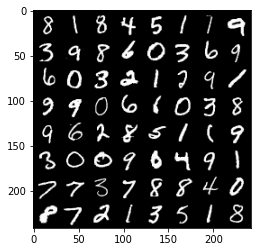

In [10]:
images, labels = dataiter.next()
show_grid(torchvision.utils.make_grid(images, normalize=True))

# Initialize Weights

In [0]:
def initialize_weights(m): 
	if type(m) == nn.Linear:
		torch.nn.init.xavier_uniform_(m.weight)
		m.bias.data.fill_(0.01)

# Generator Network

## Create Network

Hout = (Hin −1) × stride[0] − 2 × padding[0] + dilation[0] × (kernel_size[0] − 1) + output_padding[0] + 1

Wout = (Win −1) × stride[1] − 2 × padding[1] + dilation[1] × (kernel_size[1] − 1) + output_padding[1] + 1

In [0]:
class Generator(nn.Module):
  '''
  The Generator Network
  '''

  def __init__(self):
    super(Generator, self).__init__()

    self.label_emb = nn.Embedding(num_classes, num_classes)

    # First layer input -> (features + 10)
    self.linear_1 = nn.Sequential(
        nn.Linear(input_size + num_classes, 128),
        nn.LeakyReLU(0.2, inplace=True)
    )
    # Out 128

    self.linear_2 = nn.Sequential(
        nn.Linear(128, 256),
        nn.LeakyReLU(0.2, inplace=True),
        nn.BatchNorm1d(256, 0.8)
    )
    # Out 256

    self.linear_3 = nn.Sequential(
        nn.Linear(256, 512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.BatchNorm1d(512, 0.8)
    )
    # Out 512

    self.linear_4 = nn.Sequential(
        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2, inplace=True),
        nn.BatchNorm1d(1024, 0.8)
    )
    # Out 1024

    self.output_layer = nn.Sequential(
        nn.Linear(1024, image_size ** 2),
        nn.Tanh()
    )
    # Out 784
    
    self.optimizer = optim.Adam(self.parameters(), lr = 0.0002, betas = (0.5, 0.99))
    
  def forward(self, noise, labels):
    #Concat label embedding and image to produce input
    gen_input = torch.cat((self.label_emb(labels), noise), -1)
    x = self.linear_1(gen_input)
    x = self.linear_2(x)
    x = self.linear_3(x)
    x = self.linear_4(x)
    output_image = self.output_layer(x)
    output_image = output_image.view(output_image.size(0), num_channels, image_size, image_size)
    return output_image

In [13]:
generator = Generator()
generator.apply(initialize_weights)
generator.cuda()

Generator(
  (label_emb): Embedding(10, 10)
  (linear_1): Sequential(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (linear_2): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear_3): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear_4): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output_layer): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): Tanh()
 

## Test output shape of Generator

torch.Size([64, 1, 28, 28])


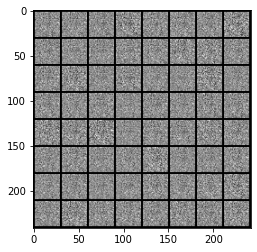

Generator(
  (label_emb): Embedding(10, 10)
  (linear_1): Sequential(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (linear_2): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear_3): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear_4): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output_layer): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): Tanh()
 

In [14]:
with torch.no_grad():
  generator.eval()
  _, labels = dataiter.next()
  noise = torch.randn(size=(batch_size, input_size)).cuda()
  output = generator(noise, labels.cuda()).detach()
  print(output.shape)
show_grid(torchvision.utils.make_grid(output.cpu(), normalize=True))
generator.train()

# Discriminator

In [0]:
class Discriminator(nn.Module):
  '''
  Discriminator neural network
  '''

  def __init__(self):
    super(Discriminator, self).__init__()

    self.label_emb = nn.Embedding(num_classes, num_classes)

    # First layer input -> (28 * 28 + 10)
    self.linear_1 = nn.Sequential(
        nn.Linear(num_classes + 28 ** 2, 512),
        nn.LeakyReLU(0.2, inplace=True),
    )
    # Out 128

    self.linear_2 = nn.Sequential(
        nn.Linear(512, 1024),
        nn.Dropout(0.4),
        nn.LeakyReLU(0.2, inplace=True)
    )
    # Out 256

    self.linear_3 = nn.Sequential(
        nn.Linear(1024, 1024),
        nn.Dropout(0.4),
        nn.LeakyReLU(0.2, inplace=True)
    )
    # Out 512

    self.linear_4 = nn.Sequential(
        nn.Linear(1024, 512),
        nn.Dropout(0.4),
        nn.LeakyReLU(0.2, inplace=True)
    )
    # Out 512

    self.output_layer = nn.Sequential(
        nn.Linear(512, 1),
        nn.Sigmoid()
    )
    # Out 1

    self.optimizer = optim.Adam(self.parameters(), lr = 0.0002, betas = (0.5, 0.99))

  def forward(self, input_image, labels):
    #Concat label embedding and image to produce input
    dis_input = torch.cat((input_image.view(input_image.size(0), -1), self.label_emb(labels)), -1)
    x = self.linear_1(dis_input)
    x = self.linear_2(x)
    x = self.linear_3(x)
    x = self.linear_4(x)
    return self.output_layer(x)

In [16]:
discriminator = Discriminator()
discriminator.apply(initialize_weights)
discriminator.cuda()

Discriminator(
  (label_emb): Embedding(10, 10)
  (linear_1): Sequential(
    (0): Linear(in_features=794, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (linear_2): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): Dropout(p=0.4, inplace=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (linear_3): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): Dropout(p=0.4, inplace=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (linear_4): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): Dropout(p=0.4, inplace=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (output_layer): Sequential(
    (0): Linear(in_features=512, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

# Loss Function

In [0]:
adversarial_loss = nn.BCELoss()

# Plotting output after each epoch

In [0]:
def plot_output():
  plt.clf()
  with torch.no_grad():
    input_noise = torch.randn(size=(num_classes, input_size)).cuda()
    fake_labels = torch.tensor([i for i in range(10)]).cuda()
    
    generator.eval()
    test_images = generator(input_noise, fake_labels)
    generator.train()
  
  show_grid(torchvision.utils.make_grid(test_images.cpu(), normalize=True, nrow=5))

# Training CGAN

Epoch: 1 / 20
Discriminator Total Loss: 0.328, Generator Total Loss: 2.226


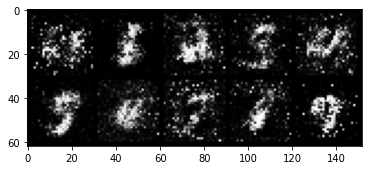

Epoch: 2 / 20
Discriminator Total Loss: 0.348, Generator Total Loss: 2.303


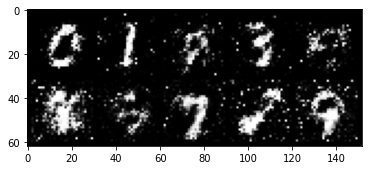

Epoch: 3 / 20
Discriminator Total Loss: 0.361, Generator Total Loss: 2.124


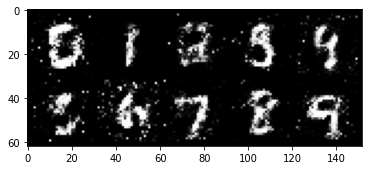

Epoch: 4 / 20
Discriminator Total Loss: 0.421, Generator Total Loss: 1.708


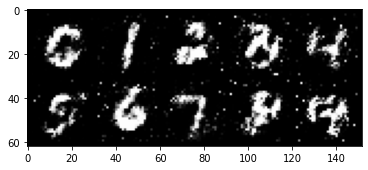

Epoch: 5 / 20
Discriminator Total Loss: 0.479, Generator Total Loss: 1.424


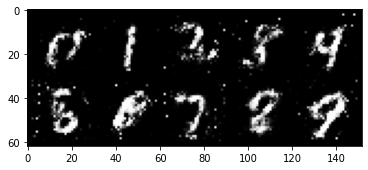

Epoch: 6 / 20
Discriminator Total Loss: 0.528, Generator Total Loss: 1.220


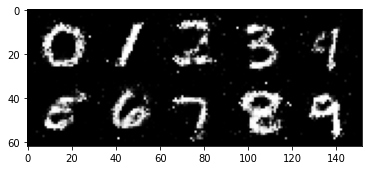

Epoch: 7 / 20
Discriminator Total Loss: 0.561, Generator Total Loss: 1.101


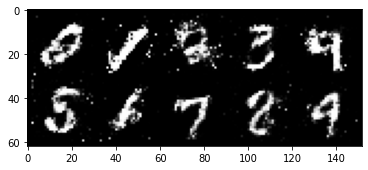

Epoch: 8 / 20
Discriminator Total Loss: 0.580, Generator Total Loss: 1.042


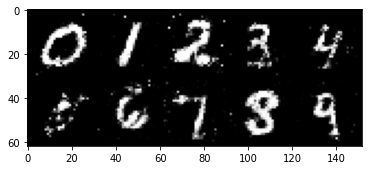

Epoch: 9 / 20
Discriminator Total Loss: 0.594, Generator Total Loss: 0.997


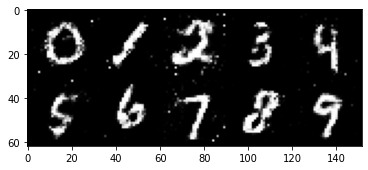

Epoch: 10 / 20
Discriminator Total Loss: 0.608, Generator Total Loss: 0.948


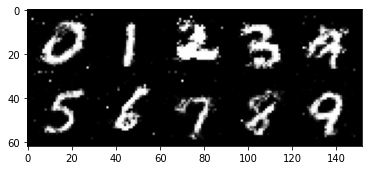

Epoch: 11 / 20
Discriminator Total Loss: 0.617, Generator Total Loss: 0.919


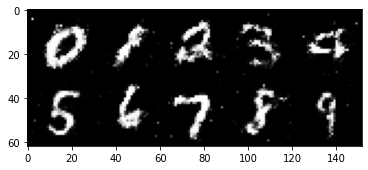

Epoch: 12 / 20
Discriminator Total Loss: 0.621, Generator Total Loss: 0.906


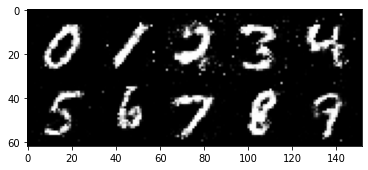

Epoch: 13 / 20
Discriminator Total Loss: 0.625, Generator Total Loss: 0.892


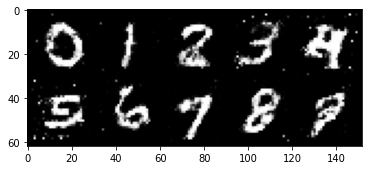

Epoch: 14 / 20
Discriminator Total Loss: 0.628, Generator Total Loss: 0.890


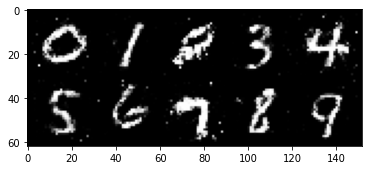

Epoch: 15 / 20
Discriminator Total Loss: 0.629, Generator Total Loss: 0.884


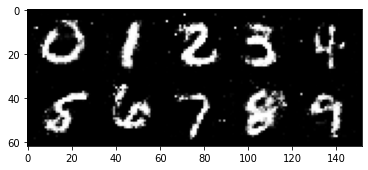

Epoch: 16 / 20
Discriminator Total Loss: 0.635, Generator Total Loss: 0.863


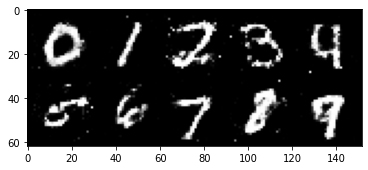

Epoch: 17 / 20
Discriminator Total Loss: 0.638, Generator Total Loss: 0.854


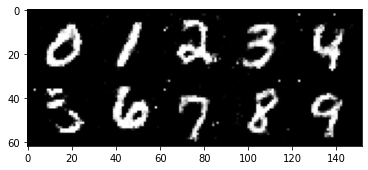

Epoch: 18 / 20
Discriminator Total Loss: 0.641, Generator Total Loss: 0.848


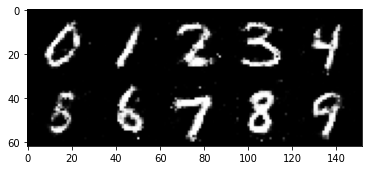

Epoch: 19 / 20
Discriminator Total Loss: 0.644, Generator Total Loss: 0.841


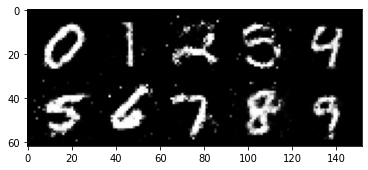

Epoch: 20 / 20
Discriminator Total Loss: 0.643, Generator Total Loss: 0.838


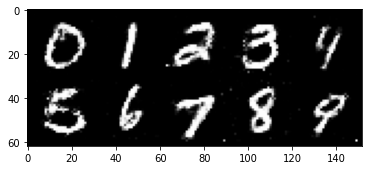

True

In [19]:
# Set tdqm for epoch progress
pbar = tqdm()

for epoch in range(epochs):
  print(f'Epoch: {epoch + 1} / {epochs}')
  pbar.reset(total=len(datasetloader))

  # Setting up losses
  discriminator_total_losses = []
  generator_total_losses = []

  for real_images, real_labels in datasetloader:
    
    # Current batch size
    current_batch_size = real_images.size()[0]

    # Convert to cuda
    real_images = real_images.cuda()
    real_labels = real_labels.cuda()

    # For real vs fake
    real_validity = torch.ones(current_batch_size).cuda()
    fake_validity = torch.zeros(current_batch_size).cuda()


    # Training generator
    generator.zero_grad()

    ## Generate fake images
    input_noise = torch.randn(size=(current_batch_size, input_size)).cuda()
    fake_labels = torch.randint(num_classes, size=(current_batch_size, )).cuda()
    
    fake_images = generator(input_noise, fake_labels)


    discriminator_fake_validity = discriminator(fake_images, fake_labels)
    
    generator_loss = adversarial_loss(discriminator_fake_validity.squeeze(), real_validity)
    generator_loss.backward()
    generator.optimizer.step()
    generator_total_losses.append(generator_loss)
    

    #Train discriminator
    discriminator.zero_grad()

    ## Loss for real images
    discriminator_real_validity = discriminator(real_images, real_labels)
    discriminator_real_loss = adversarial_loss(discriminator_real_validity.squeeze(), real_validity)

    ## Loss for fake images
    discriminator_fake_validity = discriminator(fake_images.detach(), fake_labels)
    discriminator_fake_loss = adversarial_loss(discriminator_fake_validity.squeeze(), fake_validity)

    # Total discriminator loss
    discriminator_loss = (discriminator_real_loss + discriminator_fake_loss) / 2
    discriminator_loss.backward()
    discriminator.optimizer.step()
    discriminator_total_losses.append(discriminator_loss)

    # Update tqdm
    pbar.update()

  print('Discriminator Total Loss: {:.3f}, Generator Total Loss: {:.3f}'.format(
          torch.mean(torch.FloatTensor(discriminator_total_losses)),
          torch.mean(torch.FloatTensor(generator_total_losses))
        ))


  if (epoch + 1) % output_after_every_n == 0:
    plot_output()

pbar.refresh()

# Output

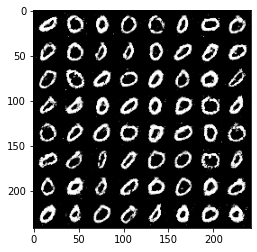

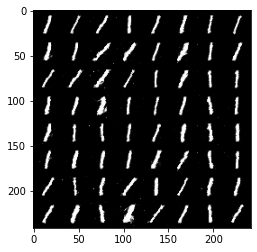

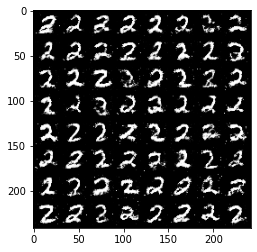

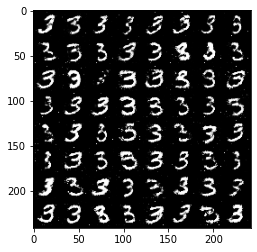

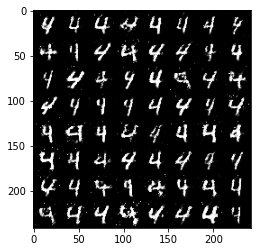

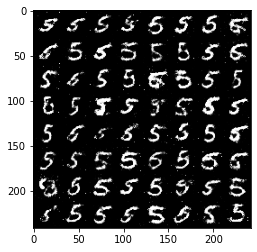

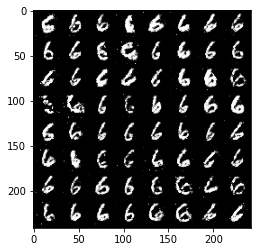

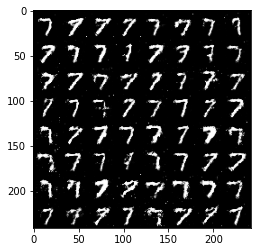

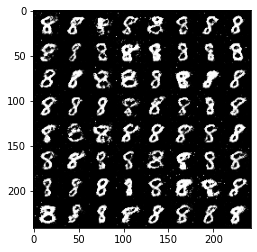

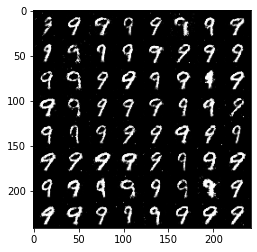

In [22]:
images = []
with torch.no_grad():
  generator.eval()

  for num in range(10):
    input_noise = torch.randn(size=(batch_size, input_size)).cuda()
    input_labels = torch.tensor([num for _ in range(batch_size)]).cuda()

    output = generator(input_noise, input_labels)

    grid = torchvision.utils.make_grid(output.cpu(), normalize=True)
    show_grid(grid)
    images.append(transforms.ToPILImage()(grid))

In [0]:
# Save gif of output
images[0].save('digitmnist-cgan.gif', save_all=True, append_images=images[1:])